In [47]:
#pip install torch

In [48]:
import torch as th
import numpy as np
import random
from tqdm import tqdm
#сделаем инициализацию random seed, 
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [49]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [50]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [51]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [52]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [53]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [54]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

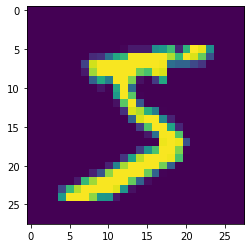

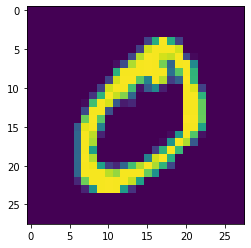

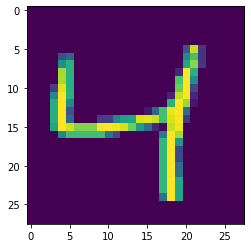

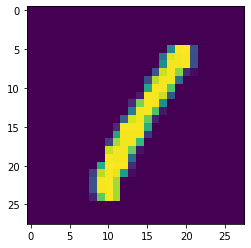

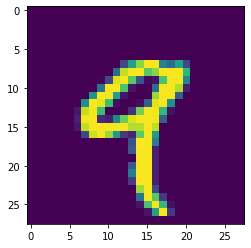

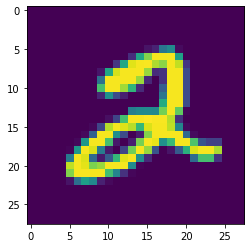

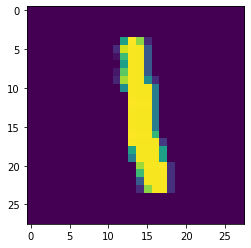

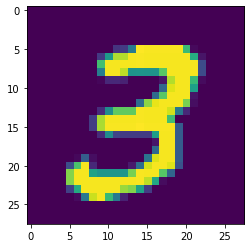

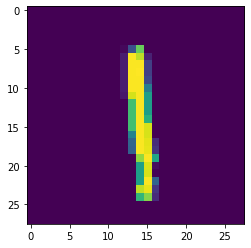

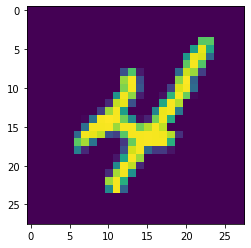

tensor(3)


In [55]:
#посмотрим на картинки
import matplotlib.pyplot as plt
for i in range(0, 10):
  plt.imshow(X_train[i, :, :])
  plt.show()
print(y_train[7])

In [56]:
#у нас трезмерный тензор, мы хотим двумерный тензор, 
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [57]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = th.nn.Linear(784, 128)
    self.fc2 = th.nn.Linear(128, 64)
    self.fc3 = th.nn.Linear(64, 10) 
    self.act = th.nn.ReLU()  
    self.sm = th.nn.Softmax(dim = 1)

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    return x

  def predict(self,x):
    x = self.forward(x)
    print(x)
    x = self.sm(x)
    return x
net = MNISTnet()

In [58]:
''' есть ли видеокарта?'''
th.cuda.is_available()

True

In [59]:
'''смотрим, занята ли карта какими либо вычислениями'''
!nvidia-smi

Wed Mar 15 11:28:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   1329MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
""" теперь нужно переложить вычисления на видеокарту"""

device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)

In [61]:
loss = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(net.parameters(), lr=0.001)

In [62]:
batch_size = 64
epochs = 15

X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
train_loss = []
epoch_counter = []
test_loss = []
epoch_s = []

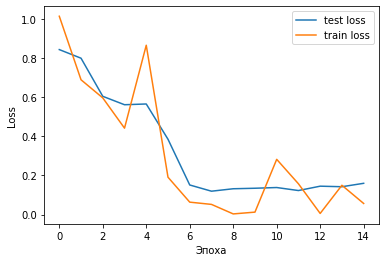

In [63]:

for epoch in range(epochs):
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    optimizer.zero_grad()
    batch_index = order[start_index:start_index+batch_size]

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()

    optimizer.step()

  train_loss.append(loss_val)
  test_preds = net.forward(X_test)
  loss_pred = loss(test_preds, y_test) 
  test_loss.append(loss_pred) 
  epoch_counter.append(epoch)
  test_preds = test_preds.argmax(dim=1)
  epoch_s.append(epoch)

for i in range(len(test_loss)):
  test_loss[i] = test_loss[i].cpu().detach().numpy()
  train_loss[i] = train_loss[i].cpu().detach().numpy()

plt.plot(epoch_s, test_loss, label='test loss')
plt.plot(epoch_s, train_loss,label='train loss')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.show()

In [64]:
def pred_test(i): 
  img = X_test[i].view(1, 784) 
  with th.no_grad():
    logps = net.predict(img)
  ps = th.exp(logps)
  probab = list(ps.cpu().numpy()[0])
  print("Прогноз =", probab.index(max(probab)))
  print("Значение =", y_test.cpu().numpy()[i])
  plt.subplots(figsize=(6,9))
  plt.imshow(X_test.cpu()[i].resize(1, 28, 28).numpy().squeeze())
  plt.show()

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, 11.4367,  0.0000,  0.0000,  0.0000,
          0.0000,  1.6643]], device='cuda:0')
Прогноз = 4
Значение = 4


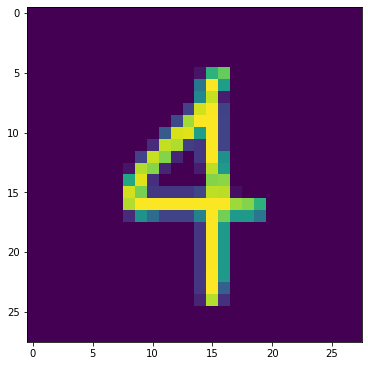

In [65]:
pred_test(159)

In [66]:
preds = net.predict(X_test)
true_vals, all_vals = 0, 0
for i in range(10000):
  probab = list(preds.cpu().detach().numpy()[i])
  if probab.index(max(probab)) == y_test.cpu().numpy()[i]:
    true_vals += 1
  else: 
    print(i, end=" ")
  all_vals += 1

print("\nNumber Of Images Tested =", all_vals)
print("Model Accuracy =", (true_vals/all_vals))

tensor([[ 0.0000,  0.0000,  5.3214,  ..., 22.4500,  0.0000,  0.1858],
        [ 0.0000,  0.0000, 56.9320,  ...,  0.0000,  2.1119,  0.0000],
        [ 0.0000, 23.7563,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  2.4457],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  5.7720,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.3244,  0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)
96 149 151 217 241 247 290 321 324 340 359 404 412 445 448 479 543 552 582 583 603 610 659 684 691 716 717 726 844 883 895 924 947 956 1014 1026 1039 1044 1107 1112 1182 1191 1226 1232 1242 1247 1260 1289 1319 1328 1393 1438 1494 1522 1527 1530 1549 1553 1569 1610 1681 1686 1692 1748 1751 1800 1813 1819 1843 1850 1878 1901 1908 1941 1952 1968 1969 1987 2004 2018 2024 2043 2044 2053 2109 2118 2121 2125 2129 2130 2135 2162 2246 2291 2329 2369 2387 2422 2433 2447 2454 2455 2488 2582 2597 2607 2648 2654 2686 2713 29

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь.
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации.
4.   Построить на одном графике loss для тестовой выборки и для обучающей.
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
6.   Замерьте время вычисления 100 эпох на CPU и на GPU.
7.   Показать результат работы модели с использованием функции predict.


Сигмоиды насыщают и уничтожают градиенты. Очень нежелательным свойством сигмовидного нейрона является то, что, когда активация нейрона насыщается в хвосте 0 или 1, градиент в этих областях почти равен нулю. Напомним, что во время обратного распространения этот (локальный) градиент будет умножен на градиент выходных данных этого шлюза для всей цели. Следовательно, если локальный градиент очень мал, это эффективно “убьет” градиент, и почти никакой сигнал не будет проходить через нейрон к его весам и рекурсивно к его данным. Кроме того, необходимо соблюдать особую осторожность при инициализации весов сигмовидных нейронов, чтобы предотвратить насыщение. Например, если начальные веса слишком велики, то большинство нейронов станут перенасыщенными, и сеть едва ли будет обучаться.
Сигмовидные выходы не имеют нулевого центра. Это нежелательно, поскольку нейроны на более поздних уровнях обработки в нейронной сети (подробнее об этом скоро) будут получать данные, которые не центрированы по нулю. Это влияет на динамику во время градиентного спуска, потому что, если данные, поступающие в нейрон, всегда положительны (например, x>0
поэлементно в f=wTx+b
)), тогда градиент по весам w
во время обратного распространения станет либо полностью положительным, либо полностью отрицательным (в зависимости от градиента всего выражения f
). Это может привести к нежелательной зигзагообразной динамике в обновлениях градиента для весов. Однако обратите внимание, что как только эти градиенты суммируются по пакету данных, окончательное обновление весов может иметь переменные знаки, что несколько смягчает эту проблему. Таким образом, это неудобство, но оно имеет менее серьезные последствия по сравнению с описанной выше проблемой насыщенной активации.

(+) Было обнаружено, что это значительно ускоряет (например, в 6 раз у Крижевского и др.) сходимость стохастического градиентного спуска по сравнению с сигмоидальными функциями / tanh. Утверждается, что это связано с его линейной, ненасыщающей формой.
(+) По сравнению с tanh / сигмовидными нейронами, которые требуют дорогостоящих операций (экспоненты и т.д.), ReLU может быть реализован простым установлением порогового значения матрицы активаций на нуле.
(-) К сожалению, блоки ReLU могут быть хрупкими во время обучения и могут “умереть”. Например, большой градиент, протекающий через нейрон ReLU, может привести к обновлению весов таким образом, что нейрон никогда больше не активируется ни в одной точке данных. Если это произойдет, то градиент, проходящий через единицу измерения, с этого момента навсегда будет равен нулю. То есть блоки ReLU могут необратимо погибнуть во время обучения, поскольку они могут быть сбиты с коллектора данных. Например, вы можете обнаружить, что до 40% вашей сети может быть “мертвой” (т.е. нейроны, которые никогда не активируются во всем обучающем наборе данных), если скорость обучения установлена слишком высокой. При правильной настройке скорости обучения это реже является проблемой.

Максимальный выход. Были предложены другие типы единиц измерения, которые не имеют функциональной формы f(wTx+b)
, где к точечному произведению между весами и данными применяется нелинейность. Одним из относительно популярных вариантов является нейрон Max out (недавно представленный Гудфеллоу и др.), который обобщает результат и его негерметичную версию. Нейрон Max out вычисляет функцию max(wT 1 x+b1,t2+b2)
. Обратите внимание, что как Reliable, так и Leaky ReLU являются частным случаем этой формы (например, для ReLU мы имеем w1,b1=0
). Таким образом, нейрон Maxout обладает всеми преимуществами ретрансляционного блока (линейный режим работы, отсутствие насыщения) и не имеет его недостатков (умирающий ReLU). Однако, в отличие от нейронов ReLU, он удваивает количество параметров для каждого отдельного нейрона, что приводит к большому общему числу параметров.